# Sorting Algorithms (Laboratory Work Nr.2)

In [28]:
import math
import timeit
import tracemalloc
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean, stdev
import pandas as pd
import sys
import numpy as np

## Input Data

In [29]:
input_sizes = [10**2, 10**3, 10**4, 10**5]

def generate_inputs(n):
    np.random.seed(42)  

    return {
        "Random": np.random.randint(0, 100000, size=n).tolist(),
        "Sorted": list(range(n)),
        "Reverse-Sorted": list(range(n, 0, -1)),
        "Few-Unique": np.random.choice([10, 20, 30, 40, 50], size=n).tolist(),
        "Nearly-Sorted": sorted(np.random.randint(0, 100000, size=n))[:n//2] + sorted(np.random.randint(0, 100000, size=n))[n//2:]
    }

input_data = {size: generate_inputs(size) for size in input_sizes}

## Performance Measurement Functions
These functions will track execution time and memory usage.

In [30]:
# Measure execution time
def measure_time(func, n, repetitions=5):
    times = timeit.repeat(lambda: func(n), repeat=repetitions, number=1)
    avg_time = sum(times) / repetitions
    std_time = (sum((t - avg_time) ** 2 for t in times) / repetitions) ** 0.5
    return avg_time, std_time

In [31]:
# Measure memory usage
def measure_memory(func, n):
    tracemalloc.start()
    func(n)
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    return peak

## Experiment Function

In [32]:
def run_experiment(func, input_sizes, repetitions=5):
    results = {size: {'time': None, 'std_time': None, 'memory': None} for size in input_sizes}

    print(f'{"Input Size":>10} | {"Time (s)":>12} | {"Memory (bytes)":>15}')
    print('-' * 42)

    for n in tqdm(input_sizes, desc="Running experiments"):
        try:
            avg_time, std_time = measure_time(func, n, repetitions=repetitions)
            memory_used = measure_memory(func, n)

            results[n]['time'] = avg_time
            results[n]['std_time'] = std_time
            results[n]['memory'] = memory_used

            print(f'{n:10d} | {avg_time:12.6f} ± {std_time:.6f} | {memory_used:15,}')
        except Exception as e:
            print(f"Error at input size {n}: {e}")
    return results

## Visualization Function

In [33]:
def create_results_table(algorithm_results, input_sizes):
    columns = ["Algorithm"] + input_sizes
    table_data = []

    for algo_name, results in algorithm_results.items():
        row = [algo_name] + [results[n]['time'] for n in input_sizes]
        table_data.append(row)

    df_results = pd.DataFrame(table_data, columns=columns)
    print("\nSorting Algorithm Performance Table:")
    print(df_results)
    return df_results

In [34]:
import numpy as np
import matplotlib.pyplot as plt

def plot_per_dataset_type(all_results_standard, all_results_optimized, dataset_types, sorting_algorithms):
    cols = 2  
    rows = len(dataset_types)

    fig, axes = plt.subplots(rows, cols, figsize=(12, 5 * rows), squeeze=False)
    
    for i, dataset in enumerate(dataset_types):
        dataset_key = dataset
    
        
        if dataset_key not in all_results_standard or dataset_key not in all_results_optimized:
            print(f"Warning: No data found for dataset '{dataset_key}'")
            continue

        # Left graph: Standard sorting
        ax1 = axes[i, 0]
        ax1.set_title(f"Standard Sorting on {dataset} Dataset")

        if dataset_key in all_results_standard:
            for algo_name in sorting_algorithms:
                if algo_name in all_results_standard[dataset_key]:
                    results = all_results_standard[dataset_key][algo_name]
                    
                    if not results:
                        print(f"Skipping {algo_name} for {dataset} (no results)")
                        continue
                    
                    sizes = sorted(results.keys())
                    times = np.array([results[n].get('time', np.nan) if results[n].get('time') is not None else np.nan for n in sizes], dtype=np.float64)
                    
                    print(f"Plotting Standard: {dataset} - {algo_name}")
                    print(f"Sizes: {sizes}")
                    print(f"Times: {times}")

                    if not sizes or np.all(np.isnan(times)):
                        print(f"Skipping {dataset} - {algo_name} (No valid data)")
                        continue
                    
                    ax1.plot(sizes, times, marker='o', label=algo_name)

        ax1.set_xscale("log")
        ax1.set_yscale("log")
        ax1.set_xlabel("Input Size (n)")
        ax1.set_ylabel("Execution Time (s)")
        ax1.legend()
        ax1.grid(True, which="both", linestyle="--", linewidth=0.5)

        # Right graph: Optimized sorting
        ax2 = axes[i, 1]
        ax2.set_title(f"Optimized Sorting on {dataset} Dataset")

        if dataset_key in all_results_optimized:
            for algo_name in sorting_algorithms:
                optimized_algo_name = f"Optimized {algo_name}" 
                if optimized_algo_name in all_results_optimized[dataset_key]:
                    results = all_results_optimized[dataset_key][optimized_algo_name]
                    
                    if not results:
                        print(f"Skipping {optimized_algo_name} for {dataset} (no results)")
                        continue
                    
                    sizes = sorted(results.keys())
                    times = np.array([results[n].get('time', np.nan) if results[n].get('time') is not None else np.nan for n in sizes], dtype=np.float64)
                    
                    print(f"Plotting Optimized: {dataset} - {optimized_algo_name}")
                    print(f"Sizes: {sizes}")
                    print(f"Times: {times}")
                    
                    if not sizes or np.all(np.isnan(times)):
                        print(f"Skipping {dataset} - {optimized_algo_name} (No valid data)")
                        continue
                    
                    ax2.plot(sizes, times, marker='s', linestyle="--", label=optimized_algo_name)

        ax2.set_xscale("log")
        ax2.set_yscale("log")
        ax2.set_xlabel("Input Size (n)")
        ax2.set_ylabel("Execution Time (s)")
        ax2.legend()
        ax2.grid(True, which="both", linestyle="--", linewidth=0.5)

    plt.tight_layout()
    plt.show()

In [35]:
def analyze_algorithm(func, algorithm_name, input_sizes, repetitions=5):
    print(f'\nAnalyzing {algorithm_name}...')
    results = run_experiment(func, input_sizes, repetitions)
    return results

## Quick Sort

Lomuto partition scheme - Original

In [36]:
def quick_sort(arr):
    if len(arr) <= 1:
        return arr

    pivot = arr[-1]
    smaller, equal, larger = [], [], []

    for num in arr:
        if num < pivot:
            smaller.append(num)
        elif num == pivot:
            equal.append(num)
        else:
            larger.append(num)

    return quick_sort(smaller) + equal + quick_sort(larger)

In [37]:
def partition(arr, low, high):
    pivot = arr[high] 
    i = low

    for j in range(low, high):
        if arr[j] < pivot:
            arr[i], arr[j] = arr[j], arr[i]
            i += 1

    arr[i], arr[high] = arr[high], arr[i] 
    return i

Optimized Version (Median of Three - Pivot Selection)

In [38]:
def optimized_quick_sort(arr):
    if len(arr) <= 1:
        return arr

    first = arr[0]
    middle = arr[len(arr) // 2]
    last = arr[-1]
    pivot = sorted([first, middle, last])[1]  

    left = [x for x in arr if x < pivot]
    middle = [x for x in arr if x == pivot]
    right = [x for x in arr if x > pivot]

    return optimized_quick_sort(left) + middle + optimized_quick_sort(right)


## Merge Sort

In [39]:
def merge_sort(arr):
    if len(arr) > 1:
        left_arr = arr[:len(arr)//2]
        right_arr = arr[len(arr)//2:]

        merge_sort(left_arr)
        merge_sort(right_arr)

        i = 0
        j = 0
        k = 0

        while i < len(left_arr) and j < len(right_arr):
            if left_arr[i] < right_arr[j]:
                arr[k] = left_arr[i]
                i += 1
            else:
                arr[k] = right_arr[j]
                j += 1
            k += 1

        while i < len(left_arr):
            arr[k] = left_arr[i]
            i += 1
            k += 1

        while j < len(right_arr):
            arr[k] = right_arr[j]
            j += 1
            k += 1

### Bootom-Up Merge Sort (Optimized)

Bottom-Up Merge Sort is an iterative (non-recursive) version of Merge Sort that avoids recursive function calls by directly merging subarrays of increasing size.

- Start with small subarrays of size 1 (individual elements).
- Merge adjacent subarrays into sorted arrays of size 2, 4, 8, 16, ..., until the entire array is merged.
- Repeat merging in increasing powers of two (size *= 2) until the entire list is sorted.

In [40]:
def merge(arr, left, mid, right):
    left_part = arr[left:mid + 1]
    right_part = arr[mid + 1:right + 1]

    i = j = 0
    k = left  

    while i < len(left_part) and j < len(right_part):
        if left_part[i] < right_part[j]:
            arr[k] = left_part[i]
            i += 1
        else:
            arr[k] = right_part[j]
            j += 1
        k += 1

    while i < len(left_part):
        arr[k] = left_part[i]
        i += 1
        k += 1

    while j < len(right_part):
        arr[k] = right_part[j]
        j += 1
        k += 1


In [41]:
def bottom_up_merge_sort(arr):
    n = len(arr)
    size = 1
    while size < n:
        for left in range(0, n, 2 * size):
            mid = min(left + size - 1, n - 1)
            right = min(left + 2 * size - 1, n - 1)
            if mid < right:
                merge(arr, left, mid, right)
        size *= 2

## Heap Sort

In [42]:
def heapify(mylist, n, i):
    max_idx = i
    left = 2 * i + 1
    right = 2 * i + 2

    if left < n and mylist[left] > mylist[max_idx]: 
        max_idx = left
    if right < n and mylist[right] > mylist[max_idx]: 
        max_idx = right
    if max_idx != i:
        mylist[i], mylist[max_idx] = mylist[max_idx], mylist[i]
        heapify(mylist, n, max_idx) 

In [43]:
def heap_sort(mylist):
    n = len(mylist)

    for i in range(n // 2 - 1, -1, -1):
        heapify(mylist, n, i)

    for i in range(n - 1, 0, -1):  
        mylist[i], mylist[0] = mylist[0], mylist[i]  
        heapify(mylist, i, 0)

Ternary Heap Sort (Optimized)

In [44]:
def heapify_ternary(arr, n, i):
    while True:
        largest = i
        left = 3 * i + 1
        mid = 3 * i + 2
        right = 3 * i + 3

        if left < n and arr[left] > arr[largest]:
            largest = left
        if mid < n and arr[mid] > arr[largest]:
            largest = mid
        if right < n and arr[right] > arr[largest]:
            largest = right

        if largest == i:
            break 

        arr[i], arr[largest] = arr[largest], arr[i]
        i = largest 

In [45]:
def heap_sort_ternary(arr):
    n = len(arr)

    # Build the ternary heap (bottom-up approach)
    for i in range(n // 3 - 1, -1, -1):
        heapify_ternary(arr, n, i)

    # Heap sort
    for i in range(n - 1, 0, -1):
        arr[i], arr[0] = arr[0], arr[i]  
        heapify_ternary(arr, i, 0)  

## Radix Sort

In [46]:
def counting_sort(arr, exp):
    n = len(arr)
    output = [0] * n  
    count = [0] * 10  

    for i in range(n):
        index = (arr[i] // exp) % 10
        count[index] += 1

    for i in range(1, 10):
        count[i] += count[i - 1]

    for i in range(n - 1, -1, -1):
        index = (arr[i] // exp) % 10
        output[count[index] - 1] = arr[i]
        count[index] -= 1

    for i in range(n):
        arr[i] = output[i]

def radix_sort(arr):
    if not arr:
        return arr

    max_num = max(arr)

    exp = 1
    while max_num // exp > 0:
        counting_sort(arr, exp)
        exp *= 10 

    return arr

Iterative MSD Radix Sort (Optimized) - for avoiding recursion depth issues

In [47]:
from collections import deque

def iterative_msd_radix_sort(arr):
    if len(arr) <= 1:
        return arr  
    
    max_num = max(arr)
    max_digit = len(str(max_num)) - 1  

    queue = deque([(arr, max_digit)])

    sorted_list = []
    
    while queue:
        current_arr, digit = queue.popleft()  

        if len(current_arr) <= 1 or digit < 0:
            sorted_list.extend(current_arr) 
            continue

        buckets = [[] for _ in range(10)]

        for num in current_arr:
            index = (num // (10 ** digit)) % 10 
            buckets[index].append(num)

        for bucket in buckets:
            if bucket:
                queue.append((bucket, digit - 1))

    return sorted_list


## Running Experiments

In [48]:
import os

all_results = {}
input_cases = ["Random", "Sorted", "Reverse-Sorted", "Few-Unique", "Nearly-Sorted"]
all_results_standard = {}
all_results_optimized = {}

In [49]:
algorithms = {
    "Quick Sort": quick_sort,
    "Merge Sort": merge_sort,
    "Heap Sort": heap_sort,
    "Radix Sort": radix_sort
}

optimized_algorithms = {
    "Optimized Quick Sort": optimized_quick_sort,
    "Optimized Merge Sort": bottom_up_merge_sort,
    "Optimized Heap Sort": heap_sort_ternary,
    "Optimized Radix Sort": iterative_msd_radix_sort,
}

In [50]:
results_folder = "results"
os.makedirs(results_folder, exist_ok=True)

### Standard Algorithms

In [51]:
for case in input_cases:
    print(f"\nRunning standard algorithms on {case} dataset...")
    algorithm_results = {}

    for algo_name, algo_func in algorithms.items():
        print(f"Running {algo_name} on {case} dataset...")
        results = analyze_algorithm(lambda n: algo_func(input_data[n][case].copy()), algo_name, input_sizes, repetitions=3)
        algorithm_results[algo_name] = results

    all_results_standard[case] = algorithm_results


Running standard algorithms on Random dataset...
Running Quick Sort on Random dataset...

Analyzing Quick Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/4 [00:00<?, ?it/s]

       100 |     0.001416 ± 0.000167 |      24,086,152
      1000 |     0.001669 ± 0.000105 |          37,704


Running experiments:  75%|███████▌  | 3/4 [00:00<00:00, 10.44it/s]

     10000 |     0.029182 ± 0.002308 |         574,974


Running experiments: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


    100000 |     0.451955 ± 0.146950 |       5,638,824
Running Merge Sort on Random dataset...

Analyzing Merge Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/4 [00:00<?, ?it/s]

       100 |     0.000233 ± 0.000007 |           2,408
      1000 |     0.003638 ± 0.000209 |          24,000


Running experiments:  75%|███████▌  | 3/4 [00:00<00:00,  3.93it/s]

     10000 |     0.043983 ± 0.002835 |         388,146


Running experiments: 100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


    100000 |     0.692237 ± 0.125444 |       2,548,240
Running Heap Sort on Random dataset...

Analyzing Heap Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/4 [00:00<?, ?it/s]

       100 |     0.000307 ± 0.000028 |             880
      1000 |     0.006687 ± 0.001761 |           8,316


Running experiments:  75%|███████▌  | 3/4 [00:00<00:00,  4.16it/s]

     10000 |     0.073940 ± 0.017742 |          80,572


Running experiments: 100%|██████████| 4/4 [00:08<00:00,  2.10s/it]


    100000 |     0.904859 ± 0.076699 |         948,964
Running Radix Sort on Random dataset...

Analyzing Radix Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/4 [00:00<?, ?it/s]

       100 |     0.000461 ± 0.000065 |           1,792
      1000 |     0.004282 ± 0.000216 |         164,346


Running experiments:  75%|███████▌  | 3/4 [00:00<00:00,  3.13it/s]

     10000 |     0.040649 ± 0.006140 |         309,726


Running experiments: 100%|██████████| 4/4 [00:09<00:00,  2.31s/it]


    100000 |     0.454690 ± 0.055779 |       1,748,988

Running standard algorithms on Sorted dataset...
Running Quick Sort on Sorted dataset...

Analyzing Quick Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/4 [00:00<?, ?it/s]

       100 |     0.000759 ± 0.000143 |          60,128


Running experiments:  50%|█████     | 2/4 [00:00<00:00,  4.81it/s]

      1000 |     0.064051 ± 0.003433 |       4,610,798


Running experiments:  75%|███████▌  | 3/4 [00:03<00:01,  1.26s/it]

Error at input size 10000: maximum recursion depth exceeded


Running experiments: 100%|██████████| 4/4 [00:30<00:00,  7.64s/it]


Error at input size 100000: maximum recursion depth exceeded
Running Merge Sort on Sorted dataset...

Analyzing Merge Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/4 [00:00<?, ?it/s]

       100 |     0.000235 ± 0.000039 |           2,408
      1000 |     0.003642 ± 0.000611 |          24,000


Running experiments:  75%|███████▌  | 3/4 [00:00<00:00,  5.37it/s]

     10000 |     0.042172 ± 0.005327 |         388,200


Running experiments: 100%|██████████| 4/4 [00:08<00:00,  2.07s/it]


    100000 |     0.511524 ± 0.019887 |       2,548,424
Running Heap Sort on Sorted dataset...

Analyzing Heap Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/4 [00:00<?, ?it/s]

       100 |     0.000426 ± 0.000013 |             880
      1000 |     0.004665 ± 0.000231 |           8,316


Running experiments:  75%|███████▌  | 3/4 [00:00<00:00,  4.55it/s]

     10000 |     0.095877 ± 0.002789 |          80,572


Running experiments: 100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


    100000 |     0.781234 ± 0.127166 |         948,956
Running Radix Sort on Sorted dataset...

Analyzing Radix Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/4 [00:00<?, ?it/s]

       100 |     0.000068 ± 0.000004 |           1,760
      1000 |     0.001284 ± 0.000031 |         164,514


Running experiments:  75%|███████▌  | 3/4 [00:00<00:00,  4.52it/s]

     10000 |     0.035018 ± 0.001377 |         309,780


Running experiments: 100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


    100000 |     0.327439 ± 0.015828 |       1,600,604

Running standard algorithms on Reverse-Sorted dataset...
Running Quick Sort on Reverse-Sorted dataset...

Analyzing Quick Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/4 [00:00<?, ?it/s]

       100 |     0.000900 ± 0.000110 |          66,392


Running experiments:  50%|█████     | 2/4 [00:00<00:00,  4.50it/s]

      1000 |     0.071594 ± 0.010275 |       4,674,808


Running experiments:  75%|███████▌  | 3/4 [00:03<00:01,  1.26s/it]

Error at input size 10000: maximum recursion depth exceeded
Error at input size 100000: maximum recursion depth exceeded


Running experiments: 100%|██████████| 4/4 [00:38<00:00,  9.66s/it]


Running Merge Sort on Reverse-Sorted dataset...

Analyzing Merge Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/4 [00:00<?, ?it/s]

       100 |     0.000341 ± 0.000007 |           2,408
      1000 |     0.002681 ± 0.000057 |         172,604


Running experiments:  75%|███████▌  | 3/4 [00:00<00:00,  4.69it/s]

     10000 |     0.039912 ± 0.004279 |         389,184


Running experiments: 100%|██████████| 4/4 [00:07<00:00,  1.95s/it]


    100000 |     0.467750 ± 0.024538 |       2,548,424
Running Heap Sort on Reverse-Sorted dataset...

Analyzing Heap Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/4 [00:00<?, ?it/s]

       100 |     0.000191 ± 0.000004 |             880
      1000 |     0.003208 ± 0.000084 |         156,155


Running experiments:  75%|███████▌  | 3/4 [00:00<00:00,  5.88it/s]

     10000 |     0.058872 ± 0.014067 |         229,764


Running experiments: 100%|██████████| 4/4 [00:06<00:00,  1.68s/it]


    100000 |     0.717913 ± 0.069497 |         949,020
Running Radix Sort on Reverse-Sorted dataset...

Analyzing Radix Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/4 [00:00<?, ?it/s]

       100 |     0.000108 ± 0.000010 |           1,760
      1000 |     0.001974 ± 0.000129 |         164,883


Running experiments:  75%|███████▌  | 3/4 [00:00<00:00,  3.82it/s]

     10000 |     0.030637 ± 0.006138 |         309,780


Running experiments: 100%|██████████| 4/4 [00:08<00:00,  2.11s/it]


    100000 |     0.380642 ± 0.064844 |       1,602,384

Running standard algorithms on Few-Unique dataset...
Running Quick Sort on Few-Unique dataset...

Analyzing Quick Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments: 100%|██████████| 4/4 [00:00<00:00, 33.85it/s]


       100 |     0.000029 ± 0.000004 |           3,232
      1000 |     0.000354 ± 0.000020 |          43,384
     10000 |     0.002594 ± 0.000594 |         322,112
    100000 |     0.027389 ± 0.003967 |       3,274,976
Running Merge Sort on Few-Unique dataset...

Analyzing Merge Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/4 [00:00<?, ?it/s]

       100 |     0.000489 ± 0.000117 |           2,408
      1000 |     0.003347 ± 0.000054 |         172,793


Running experiments:  75%|███████▌  | 3/4 [00:00<00:00,  5.26it/s]

     10000 |     0.054778 ± 0.006197 |         387,736


Running experiments: 100%|██████████| 4/4 [00:07<00:00,  1.96s/it]


    100000 |     0.518483 ± 0.029711 |       2,400,040
Running Heap Sort on Few-Unique dataset...

Analyzing Heap Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/4 [00:00<?, ?it/s]

       100 |     0.000200 ± 0.000008 |             880
      1000 |     0.003120 ± 0.000058 |           8,316


Running experiments:  75%|███████▌  | 3/4 [00:00<00:00,  6.67it/s]

     10000 |     0.052894 ± 0.007140 |         229,542


Running experiments: 100%|██████████| 4/4 [00:07<00:00,  1.95s/it]


    100000 |     0.640504 ± 0.026124 |         948,964
Running Radix Sort on Few-Unique dataset...

Analyzing Radix Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/4 [00:00<?, ?it/s]

       100 |     0.000189 ± 0.000055 |           1,760
      1000 |     0.003623 ± 0.000965 |          16,572


Running experiments:  75%|███████▌  | 3/4 [00:00<00:00,  5.67it/s]

     10000 |     0.026794 ± 0.005735 |         309,724


Running experiments: 100%|██████████| 4/4 [00:03<00:00,  1.10it/s]


    100000 |     0.209741 ± 0.036033 |       1,600,572

Running standard algorithms on Nearly-Sorted dataset...
Running Quick Sort on Nearly-Sorted dataset...

Analyzing Quick Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/4 [00:00<?, ?it/s]

       100 |     0.000865 ± 0.000172 |          60,128


Running experiments:  50%|█████     | 2/4 [00:00<00:00,  4.96it/s]

      1000 |     0.054539 ± 0.011262 |       4,592,440


Running experiments:  75%|███████▌  | 3/4 [00:03<00:01,  1.33s/it]

Error at input size 10000: maximum recursion depth exceeded


Running experiments: 100%|██████████| 4/4 [00:52<00:00, 13.04s/it]


Error at input size 100000: maximum recursion depth exceeded
Running Merge Sort on Nearly-Sorted dataset...

Analyzing Merge Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/4 [00:00<?, ?it/s]

       100 |     0.000292 ± 0.000015 |           2,408
      1000 |     0.003239 ± 0.000286 |         164,364


Running experiments:  75%|███████▌  | 3/4 [00:00<00:00,  4.44it/s]

     10000 |     0.059618 ± 0.018906 |         388,038


Running experiments: 100%|██████████| 4/4 [00:08<00:00,  2.08s/it]


    100000 |     0.568380 ± 0.038478 |       2,400,040
Running Heap Sort on Nearly-Sorted dataset...

Analyzing Heap Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/4 [00:00<?, ?it/s]

       100 |     0.000432 ± 0.000078 |             880
      1000 |     0.005196 ± 0.000553 |           8,316


Running experiments:  75%|███████▌  | 3/4 [00:00<00:00,  5.55it/s]

     10000 |     0.065482 ± 0.004804 |         228,147


Running experiments: 100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


    100000 |     0.832146 ± 0.063889 |         800,764
Running Radix Sort on Nearly-Sorted dataset...

Analyzing Radix Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/4 [00:00<?, ?it/s]

       100 |     0.000417 ± 0.000067 |           1,816
      1000 |     0.006119 ± 0.001300 |          16,564


Running experiments:  75%|███████▌  | 3/4 [00:01<00:00,  2.74it/s]

     10000 |     0.037991 ± 0.003051 |         309,804


Running experiments: 100%|██████████| 4/4 [00:10<00:00,  2.70s/it]

    100000 |     0.652584 ± 0.025526 |       1,750,608


In [52]:
for case, results in all_results_standard.items():
    df_results = create_results_table(results, input_sizes)
    filename = f"sorting_results_standard_{case.lower().replace('-', '_')}.csv"
    file_path = os.path.join(results_folder, filename)
    df_results.to_csv(file_path, index=False)
    print(f"Standard results saved to {file_path}")


Sorting Algorithm Performance Table:
    Algorithm       100      1000     10000    100000
0  Quick Sort  0.001416  0.001669  0.029182  0.451955
1  Merge Sort  0.000233  0.003638  0.043983  0.692237
2   Heap Sort  0.000307  0.006687  0.073940  0.904859
3  Radix Sort  0.000461  0.004282  0.040649  0.454690
Standard results saved to results\sorting_results_standard_random.csv

Sorting Algorithm Performance Table:
    Algorithm       100      1000     10000    100000
0  Quick Sort  0.000759  0.064051       NaN       NaN
1  Merge Sort  0.000235  0.003642  0.042172  0.511524
2   Heap Sort  0.000426  0.004665  0.095877  0.781234
3  Radix Sort  0.000068  0.001284  0.035018  0.327439
Standard results saved to results\sorting_results_standard_sorted.csv

Sorting Algorithm Performance Table:
    Algorithm       100      1000     10000    100000
0  Quick Sort  0.000900  0.071594       NaN       NaN
1  Merge Sort  0.000341  0.002681  0.039912  0.467750
2   Heap Sort  0.000191  0.003208  0.058872 

### Optimized Algorithms

In [53]:
for case in input_cases:
    print(f"\nRunning optimized algorithms on {case} dataset...")
    algorithm_results = {}

    for algo_name, algo_func in optimized_algorithms.items():
        print(f"Running {algo_name} on {case} dataset...")
        results = analyze_algorithm(lambda n: algo_func(input_data[n][case].copy()), algo_name, input_sizes, repetitions=3)
        algorithm_results[algo_name] = results

    all_results_optimized[case] = algorithm_results


Running optimized algorithms on Random dataset...
Running Optimized Quick Sort on Random dataset...

Analyzing Optimized Quick Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/4 [00:00<?, ?it/s]

       100 |     0.000247 ± 0.000074 |           4,584
      1000 |     0.002997 ± 0.000223 |         186,539


Running experiments:  75%|███████▌  | 3/4 [00:00<00:00, 11.46it/s]

     10000 |     0.032374 ± 0.001244 |         541,743


Running experiments: 100%|██████████| 4/4 [00:02<00:00,  1.40it/s]


    100000 |     0.443375 ± 0.017079 |       4,206,560
Running Optimized Merge Sort on Random dataset...

Analyzing Optimized Merge Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/4 [00:00<?, ?it/s]

       100 |     0.000285 ± 0.000027 |           1,632
      1000 |     0.004417 ± 0.000283 |         164,328


Running experiments:  75%|███████▌  | 3/4 [00:01<00:00,  2.88it/s]

     10000 |     0.091453 ± 0.003908 |         308,668


Running experiments: 100%|██████████| 4/4 [00:11<00:00,  2.80s/it]


    100000 |     0.649711 ± 0.063183 |       1,750,344
Running Optimized Heap Sort on Random dataset...

Analyzing Optimized Heap Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/4 [00:00<?, ?it/s]

       100 |     0.000165 ± 0.000007 |             960
      1000 |     0.002630 ± 0.000021 |         156,345


Running experiments:  75%|███████▌  | 3/4 [00:00<00:00,  5.89it/s]

     10000 |     0.060773 ± 0.005634 |         229,476


Running experiments: 100%|██████████| 4/4 [00:06<00:00,  1.56s/it]


    100000 |     0.573860 ± 0.036958 |         800,284
Running Optimized Radix Sort on Random dataset...

Analyzing Optimized Radix Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/4 [00:00<?, ?it/s]

       100 |     0.000307 ± 0.000054 |           5,088
      1000 |     0.003970 ± 0.001417 |          69,248


Running experiments:  75%|███████▌  | 3/4 [00:00<00:00,  5.87it/s]

     10000 |     0.036094 ± 0.002266 |       1,087,514


Running experiments: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]


    100000 |     0.218308 ± 0.028251 |      10,470,008

Running optimized algorithms on Sorted dataset...
Running Optimized Quick Sort on Sorted dataset...

Analyzing Optimized Quick Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/4 [00:00<?, ?it/s]

       100 |     0.000216 ± 0.000024 |           3,536
      1000 |     0.002719 ± 0.000657 |          33,008


Running experiments:  75%|███████▌  | 3/4 [00:00<00:00,  9.66it/s]

     10000 |     0.033139 ± 0.002391 |         477,760


Running experiments: 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


    100000 |     0.554064 ± 0.119859 |       3,353,040
Running Optimized Merge Sort on Sorted dataset...

Analyzing Optimized Merge Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/4 [00:00<?, ?it/s]

       100 |     0.000545 ± 0.000062 |           1,632
      1000 |     0.005555 ± 0.000618 |         164,422


Running experiments:  75%|███████▌  | 3/4 [00:02<00:00,  1.40it/s]

     10000 |     0.161873 ± 0.019308 |         160,284


Running experiments: 100%|██████████| 4/4 [00:18<00:00,  4.73s/it]


    100000 |     0.677500 ± 0.094015 |       1,749,012
Running Optimized Heap Sort on Sorted dataset...

Analyzing Optimized Heap Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/4 [00:00<?, ?it/s]

       100 |     0.000464 ± 0.000063 |             960
      1000 |     0.008092 ± 0.001466 |           8,284


Running experiments:  75%|███████▌  | 3/4 [00:01<00:00,  2.57it/s]

     10000 |     0.137028 ± 0.045437 |          80,284


Running experiments: 100%|██████████| 4/4 [00:15<00:00,  3.90s/it]


    100000 |     1.309041 ± 0.143502 |         950,280
Running Optimized Radix Sort on Sorted dataset...

Analyzing Optimized Radix Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/4 [00:00<?, ?it/s]

       100 |     0.000253 ± 0.000013 |           6,992
      1000 |     0.002046 ± 0.000321 |         176,998


Running experiments:  75%|███████▌  | 3/4 [00:00<00:00,  7.43it/s]

     10000 |     0.028308 ± 0.002013 |       1,635,083


Running experiments: 100%|██████████| 4/4 [00:05<00:00,  1.29s/it]


    100000 |     0.553864 ± 0.056969 |      15,910,432

Running optimized algorithms on Reverse-Sorted dataset...
Running Optimized Quick Sort on Reverse-Sorted dataset...

Analyzing Optimized Quick Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/4 [00:00<?, ?it/s]

       100 |     0.000317 ± 0.000058 |           3,608
      1000 |     0.003015 ± 0.000263 |         181,718


Running experiments:  75%|███████▌  | 3/4 [00:00<00:00, 10.58it/s]

     10000 |     0.041514 ± 0.013922 |         459,048


Running experiments: 100%|██████████| 4/4 [00:02<00:00,  1.34it/s]


    100000 |     0.404413 ± 0.054325 |       3,353,048
Running Optimized Merge Sort on Reverse-Sorted dataset...

Analyzing Optimized Merge Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/4 [00:00<?, ?it/s]

       100 |     0.000383 ± 0.000055 |           1,632
      1000 |     0.004270 ± 0.000634 |         164,234


Running experiments:  75%|███████▌  | 3/4 [00:01<00:00,  2.32it/s]

     10000 |     0.080426 ± 0.029972 |         307,859


Running experiments: 100%|██████████| 4/4 [00:13<00:00,  3.46s/it]


    100000 |     0.705478 ± 0.077293 |       1,750,312
Running Optimized Heap Sort on Reverse-Sorted dataset...

Analyzing Optimized Heap Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/4 [00:00<?, ?it/s]

       100 |     0.000184 ± 0.000006 |             960
      1000 |     0.003119 ± 0.000018 |           8,284


Running experiments:  75%|███████▌  | 3/4 [00:00<00:00,  5.30it/s]

     10000 |     0.056297 ± 0.005719 |         229,380


Running experiments: 100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


    100000 |     0.658296 ± 0.032821 |         800,284
Running Optimized Radix Sort on Reverse-Sorted dataset...

Analyzing Optimized Radix Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/4 [00:00<?, ?it/s]

       100 |     0.000170 ± 0.000014 |           6,920
      1000 |     0.003376 ± 0.000926 |         101,240


Running experiments:  75%|███████▌  | 3/4 [00:00<00:00, 10.47it/s]

     10000 |     0.025989 ± 0.006921 |       1,634,952


Running experiments: 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]


    100000 |     0.247300 ± 0.020647 |      16,058,632

Running optimized algorithms on Few-Unique dataset...
Running Optimized Quick Sort on Few-Unique dataset...

Analyzing Optimized Quick Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/4 [00:00<?, ?it/s]

       100 |     0.000088 ± 0.000009 |           3,232
      1000 |     0.000511 ± 0.000019 |          43,384
     10000 |     0.003886 ± 0.000204 |         364,808
    100000 |     0.043397 ± 0.007215 |       3,274,976


Running experiments: 100%|██████████| 4/4 [00:00<00:00, 20.25it/s]


Running Optimized Merge Sort on Few-Unique dataset...

Analyzing Optimized Merge Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/4 [00:00<?, ?it/s]

       100 |     0.000582 ± 0.000040 |           1,632


Running experiments:  50%|█████     | 2/4 [00:00<00:00, 18.43it/s]

      1000 |     0.008972 ± 0.002436 |          16,284
     10000 |     0.101265 ± 0.013822 |         160,284


Running experiments: 100%|██████████| 4/4 [00:14<00:00,  3.53s/it]


    100000 |     0.775723 ± 0.088580 |       1,748,668
Running Optimized Heap Sort on Few-Unique dataset...

Analyzing Optimized Heap Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/4 [00:00<?, ?it/s]

       100 |     0.000160 ± 0.000010 |             960
      1000 |     0.002292 ± 0.000066 |           8,284


Running experiments:  75%|███████▌  | 3/4 [00:00<00:00,  8.22it/s]

     10000 |     0.038195 ± 0.003037 |         229,476


Running experiments: 100%|██████████| 4/4 [00:05<00:00,  1.39s/it]


    100000 |     0.483413 ± 0.052441 |         950,280
Running Optimized Radix Sort on Few-Unique dataset...

Analyzing Optimized Radix Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/4 [00:00<?, ?it/s]

       100 |     0.000122 ± 0.000018 |           2,888
      1000 |     0.000418 ± 0.000027 |          19,560
     10000 |     0.005394 ± 0.000903 |         185,896
    100000 |     0.050499 ± 0.007413 |       1,838,696


Running experiments: 100%|██████████| 4/4 [00:00<00:00, 18.76it/s]



Running optimized algorithms on Nearly-Sorted dataset...
Running Optimized Quick Sort on Nearly-Sorted dataset...

Analyzing Optimized Quick Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/4 [00:00<?, ?it/s]

       100 |     0.000208 ± 0.000010 |           3,536
      1000 |     0.002849 ± 0.000185 |         176,348


Running experiments:  75%|███████▌  | 3/4 [00:00<00:00,  7.96it/s]

     10000 |     0.045418 ± 0.016017 |         477,585


Running experiments: 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]


    100000 |     0.571304 ± 0.063691 |       3,353,264
Running Optimized Merge Sort on Nearly-Sorted dataset...

Analyzing Optimized Merge Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/4 [00:00<?, ?it/s]

       100 |     0.000359 ± 0.000056 |           1,632
      1000 |     0.004584 ± 0.000074 |         164,000


Running experiments:  75%|███████▌  | 3/4 [00:01<00:00,  2.67it/s]

     10000 |     0.056273 ± 0.002158 |         307,859


Running experiments: 100%|██████████| 4/4 [00:15<00:00,  4.00s/it]


    100000 |     0.987565 ± 0.090872 |       1,749,012
Running Optimized Heap Sort on Nearly-Sorted dataset...

Analyzing Optimized Heap Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/4 [00:00<?, ?it/s]

       100 |     0.000259 ± 0.000010 |             960
      1000 |     0.003923 ± 0.000203 |         156,878


Running experiments:  75%|███████▌  | 3/4 [00:00<00:00,  4.94it/s]

     10000 |     0.058803 ± 0.006413 |         228,170


Running experiments: 100%|██████████| 4/4 [00:08<00:00,  2.20s/it]


    100000 |     0.804960 ± 0.047087 |         950,280
Running Optimized Radix Sort on Nearly-Sorted dataset...

Analyzing Optimized Radix Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/4 [00:00<?, ?it/s]

       100 |     0.000229 ± 0.000033 |           6,064
      1000 |     0.003104 ± 0.000199 |         217,170


Running experiments:  75%|███████▌  | 3/4 [00:00<00:00,  4.67it/s]

     10000 |     0.039964 ± 0.002362 |       1,085,314


Running experiments: 100%|██████████| 4/4 [00:05<00:00,  1.46s/it]

    100000 |     0.433796 ± 0.054515 |      10,347,224


In [54]:
for case, results in all_results_optimized.items():
    df_results = create_results_table(results, input_sizes)
    filename = f"sorting_results_optimized_{case.lower().replace('-', '_')}.csv"
    file_path = os.path.join(results_folder, filename)
    df_results.to_csv(file_path, index=False)
    print(f"Optimized results saved to {file_path}")


Sorting Algorithm Performance Table:
              Algorithm       100      1000     10000    100000
0  Optimized Quick Sort  0.000247  0.002997  0.032374  0.443375
1  Optimized Merge Sort  0.000285  0.004417  0.091453  0.649711
2   Optimized Heap Sort  0.000165  0.002630  0.060773  0.573860
3  Optimized Radix Sort  0.000307  0.003970  0.036094  0.218308
Optimized results saved to results\sorting_results_optimized_random.csv

Sorting Algorithm Performance Table:
              Algorithm       100      1000     10000    100000
0  Optimized Quick Sort  0.000216  0.002719  0.033139  0.554064
1  Optimized Merge Sort  0.000545  0.005555  0.161873  0.677500
2   Optimized Heap Sort  0.000464  0.008092  0.137028  1.309041
3  Optimized Radix Sort  0.000253  0.002046  0.028308  0.553864
Optimized results saved to results\sorting_results_optimized_sorted.csv

Sorting Algorithm Performance Table:
              Algorithm       100      1000     10000    100000
0  Optimized Quick Sort  0.000317  0.0

## Graph Visualization and Comparison

Plotting Standard: Random - Quick Sort
Sizes: [100, 1000, 10000, 100000]
Times: [0.0014158  0.00166937 0.02918173 0.45195467]
Plotting Standard: Random - Merge Sort
Sizes: [100, 1000, 10000, 100000]
Times: [2.33099995e-04 3.63846666e-03 4.39833333e-02 6.92236900e-01]
Plotting Standard: Random - Heap Sort
Sizes: [100, 1000, 10000, 100000]
Times: [3.07433336e-04 6.68723334e-03 7.39395667e-02 9.04859367e-01]
Plotting Standard: Random - Radix Sort
Sizes: [100, 1000, 10000, 100000]
Times: [0.00046103 0.00428247 0.0406487  0.45469017]
Plotting Optimized: Random - Optimized Quick Sort
Sizes: [100, 1000, 10000, 100000]
Times: [2.47366668e-04 2.99676666e-03 3.23737000e-02 4.43374900e-01]
Plotting Optimized: Random - Optimized Merge Sort
Sizes: [100, 1000, 10000, 100000]
Times: [2.85400005e-04 4.41733333e-03 9.14525000e-02 6.49711067e-01]
Plotting Optimized: Random - Optimized Heap Sort
Sizes: [100, 1000, 10000, 100000]
Times: [1.64500001e-04 2.63026667e-03 6.07728333e-02 5.73859833e-01]
Plottin

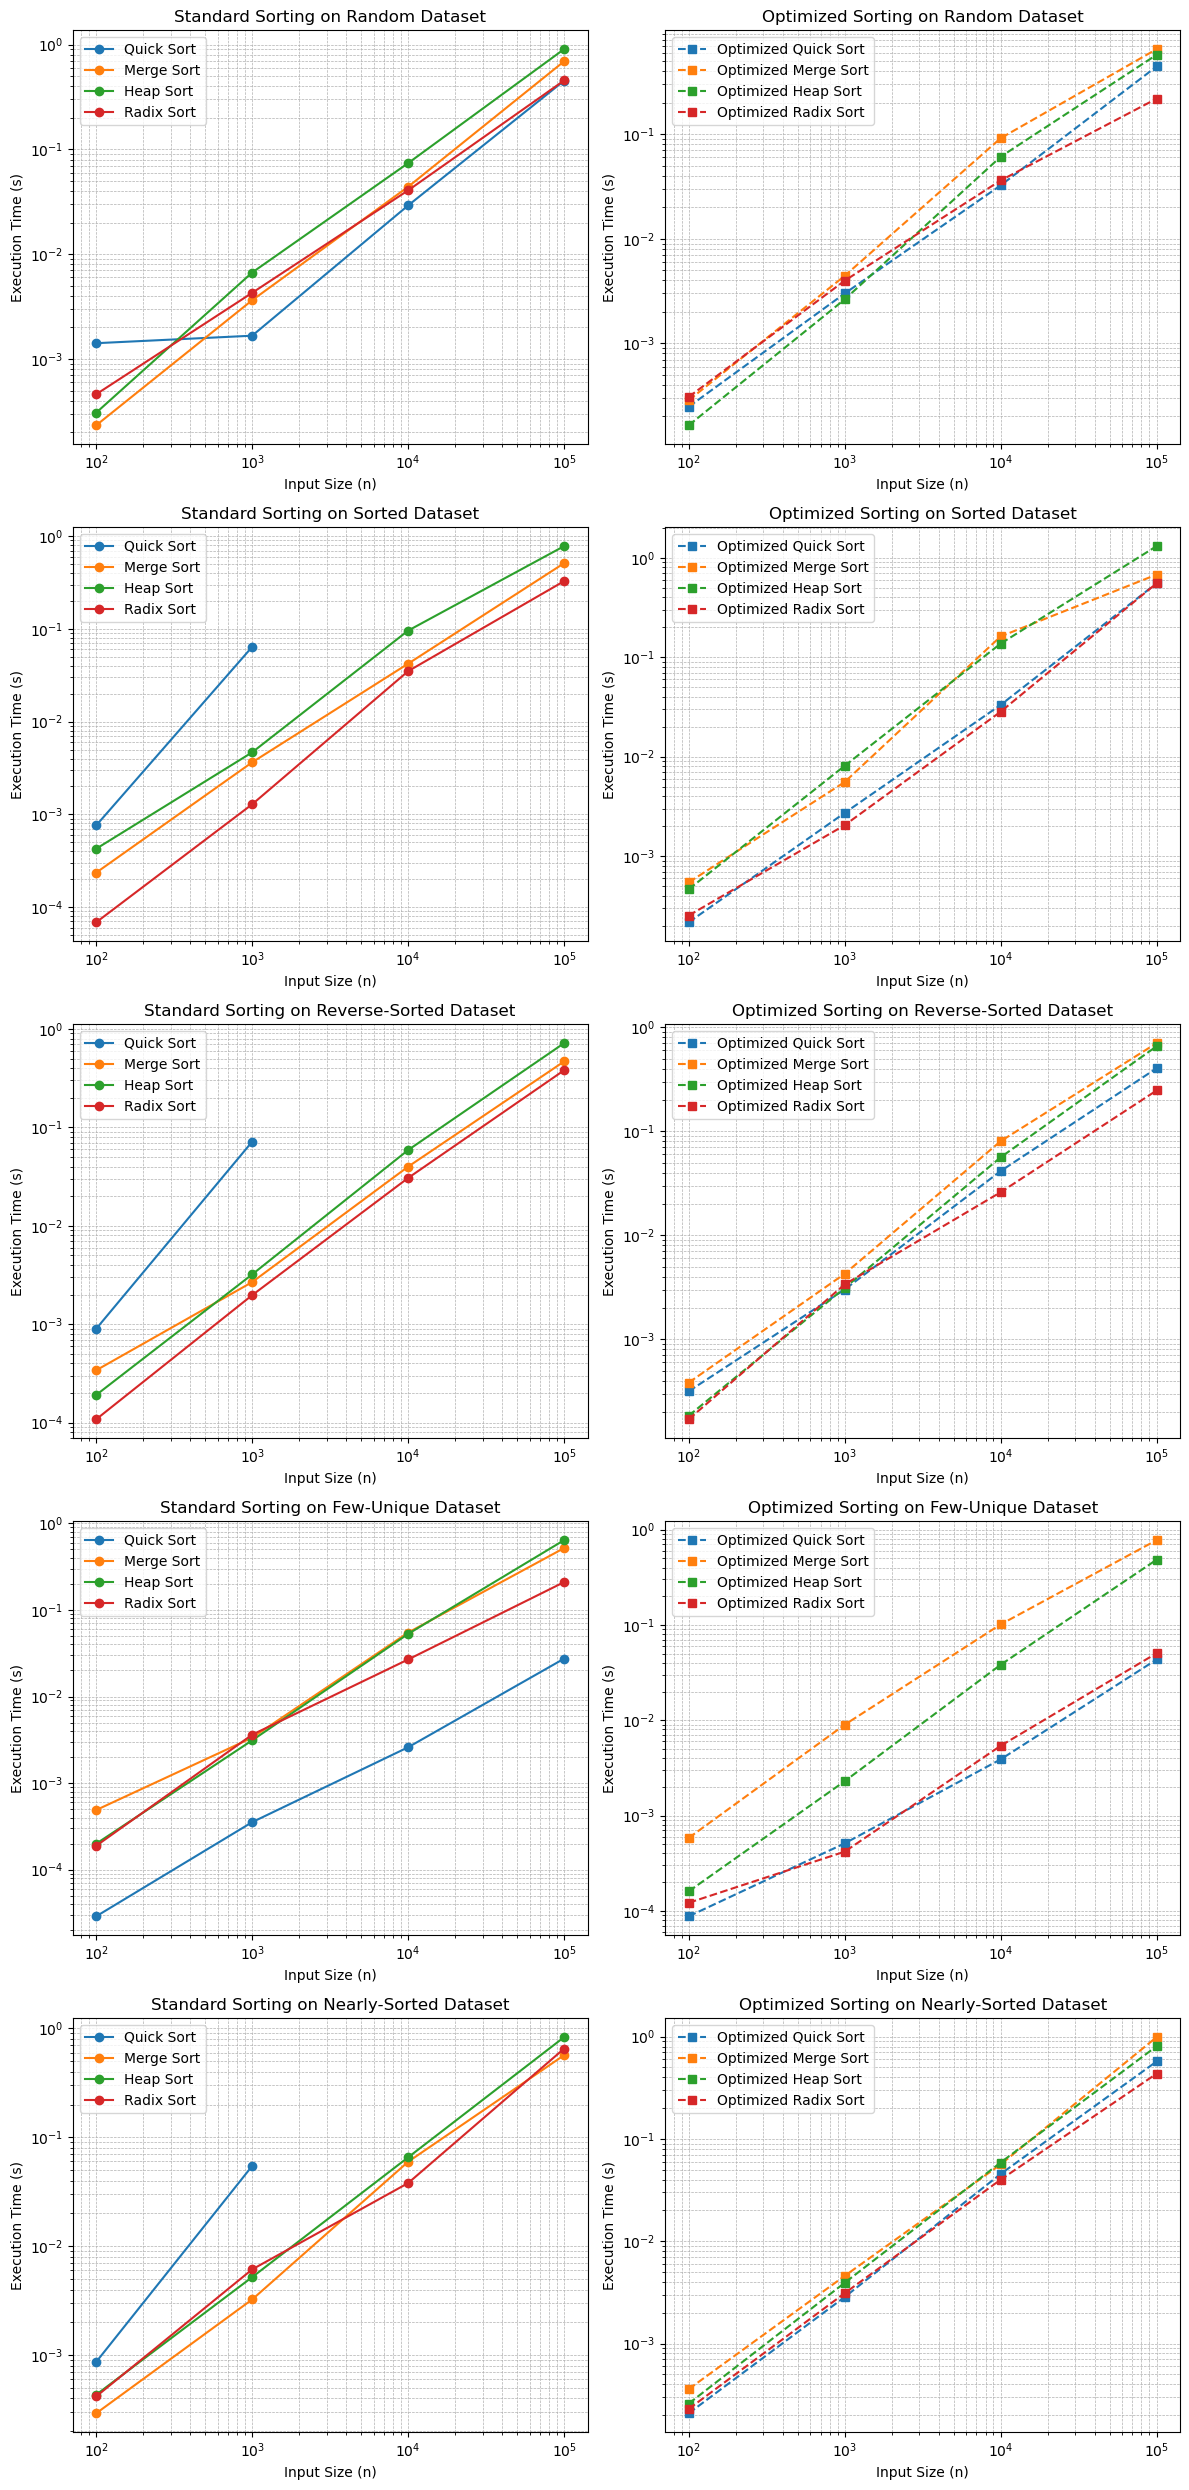

In [55]:
dataset_types = ["Random", "Sorted", "Reverse-Sorted", "Few-Unique", "Nearly-Sorted"]
sorting_algorithms = list(algorithms.keys()) 
plot_per_dataset_type(all_results_standard, all_results_optimized, dataset_types, sorting_algorithms)